# Importing Libraries 

In [66]:
import pandas as pd
import numpy as np
import sklearn

# Visualization Libraies
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

# to split the dataset into test and train 
from sklearn.model_selection import train_test_split

# For Custom Transformer
from sklearn.base import BaseEstimator, TransformerMixin

# Transformers for the Pipeline
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
import category_encoders
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Evaluation metrics
from sklearn.metrics import accuracy_score

# Cross Validation libraries
from sklearn.model_selection import cross_val_score

# Predictors 
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# For deployment 
import joblib           # pickle the pipeline
from joblib import dump

# Loading in the Dataset 
source: https://www.kaggle.com/kemical/kickstarter-projects/notebooks?sortBy=dateRun&group=upvoted&pageSize=20&datasetId=4104

In [2]:
# To view all the columns 
pd.set_option('display.max_columns', None)

df = pd.read_csv('kickstarter.csv', 
                parse_dates=['deadline', 'launched'])
df.head(5)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


Ideas:
- delete ID
- feature engineering (deadline and launched)
- Consider top five countries
- Only consider failed or successful and make it a binary classifictaion
- Will keep all the 15 main categories
- For category we could pass it to the ordinal encoding 

# EDA

In [3]:
total_nan = df.isna().sum().sort_values(ascending=False)
percentage_nan = (total_nan / df.shape[0]) * 100
tabel = pd.concat([total_nan, percentage_nan], axis=1, keys=['Total NAN', 'Percentage of NAN'])
tabel

,Total NAN,Percentage of NAN
usd pledged,3797,1.002744
name,4,0.001056
usd_goal_real,0,0.000000
usd_pledged_real,0,0.000000
country,0,0.000000
backers,0,0.000000
state,0,0.000000
pledged,0,0.000000
launched,0,0.000000
goal,0,0.000000


In [4]:
df.state.value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

In [5]:
# filtering out the dataset for binary target variable - failed / successful
df = df.loc[(df['state'] == 'failed') | (df['state'] == 'successful')]
df.state.value_counts()

failed        197719
successful    133956
Name: state, dtype: int64

In [6]:
# Imbalance classification but not worrisome
successful = 131490/(192871+131490)
successful

0.4053816580908309

In [7]:
# changing the target variable to 0 and 1 
df['state'] = df['state'].map({'failed':0, 'successful':1})
df['state'].value_counts()

0    197719
1    133956
Name: state, dtype: int64

# Checking for leakage

In [8]:
df.loc[df['usd_pledged_real'] < df['usd_goal_real']]['state'].value_counts()

0    197713
1         5
Name: state, dtype: int64

In [9]:
# checking for backers
df.loc[df['backers'] > 70]['state'].value_counts()

1    67142
0     9151
Name: state, dtype: int64

In [10]:
df.loc[df['usd_pledged_real'] > 25000]['state'].value_counts()

1    19463
0     1374
Name: state, dtype: int64

In [11]:
df.loc[df['usd_pledged_real'] > 25000].shape

(20837, 15)

There is clearly a data leakage here. 

## Deleting verticals that we don't need 
- Dropping USD pledged and pledged as usd_pledged_real has the same information
- Dropping country as currency and country are highly correlated
- Dropping goal as we have goal converted in USD as a vertical
- Dropping backers and 

In [12]:
df = df.drop(['usd pledged', 'pledged', 'country', 'goal', 'ID', 'usd_pledged_real', 'backers'], axis=1) 
df.shape

(331675, 8)

In [13]:
# dropping 4 nan values in name
df.dropna(axis=0, inplace=True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331672 entries, 0 to 378660
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   name           331672 non-null  object        
 1   category       331672 non-null  object        
 2   main_category  331672 non-null  object        
 3   currency       331672 non-null  object        
 4   deadline       331672 non-null  datetime64[ns]
 5   launched       331672 non-null  datetime64[ns]
 6   state          331672 non-null  int64         
 7   usd_goal_real  331672 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(1), object(4)
memory usage: 22.8+ MB


## Checking high cardinality 

In [15]:
cols = ['category', 'main_category', 'currency']

for col in cols:
    print(f"{col} has {df[col].nunique()} unique values")

category has 159 unique values
main_category has 15 unique values
currency has 14 unique values


In [16]:
# Either we can delete category vertical or ordinal encode it!
df.category.value_counts()

Product Design     18680
Documentary        14523
Music              12633
Tabletop Games     11744
Shorts             11394
                   ...  
Residencies           68
Letterpress           46
Chiptune              33
Literary Spaces       19
Taxidermy             10
Name: category, Length: 159, dtype: int64

In [17]:
# Lets consider top 5 currencies and delete the rest 
df.currency.value_counts()

USD    261509
GBP     29475
EUR     14378
CAD     12375
AUD      6621
SEK      1510
MXN      1411
NZD      1274
DKK       929
CHF       652
NOK       584
HKD       477
SGD       454
JPY        23
Name: currency, dtype: int64

In [18]:
# Filtering out top 5 currencies 
df = df.loc[(df['currency'] == 'USD') | (df['currency'] == 'GBP') | (df['currency'] == 'EUR') \
      | (df['currency'] == 'CAD') | (df['currency'] == 'AUD')]

In [19]:
# changing the currency names into countries so it will be easier to ask a user for input
df['currency'] = df['currency'].map({
                'USD':'USA',
                'GBP':'UK',
                'EUR':'Europe',
                'CAD':'Canada',
                'AUD': 'Australia'})
df.currency.value_counts()

USA          261509
UK            29475
Europe        14378
Canada        12375
Australia      6621
Name: currency, dtype: int64

In [20]:
# reset index as we deleted a few rows when we filtered
df.reset_index(drop=True, inplace=True)

# Feature Engineering 
- calculating the length of the campaign from deadline and launched 
- calculating the total number of words in name 

In [21]:
# making a new column length_days
df['length_days'] = (df['deadline'] - df['launched']).dt.days + 1

# deleting deadline and launched cols
df = df.drop(['deadline', 'launched'], axis=1)

In [22]:
# Total number of words in each row in name
df['name'] = df['name'].str.split().str.len()

# Baseline Model 

In [23]:
# we need our model to beat this score
baseline = 1 - successful
baseline

0.5946183419091691

# Split Dataset

In [24]:
# Feature Matrix and Target Variable
X = df.drop('state', axis=1)
y = df['state']

In [25]:
# Splitting the dataset into train and test dataset 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=105)

In [26]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(259486, 6)
(64872, 6)
(259486,)
(64872,)


In [27]:
X_train.head()

,name,category,main_category,currency,usd_goal_real,length_days
87131,3,Technology,Technology,USA,8000.00,20
181947,3,Documentary,Film & Video,Canada,47824.01,15
86969,11,Art,Art,USA,25000.00,31
149100,3,Nonfiction,Publishing,Australia,2816.37,35
114517,1,Documentary,Film & Video,UK,32037.42,41


# Pipeline 

In [28]:
# looking at numerical attributes for simple imputer with median 
num_attribs = X_train.select_dtypes(exclude='object')
num_attribs.columns

Index(['name', 'usd_goal_real', 'length_days'], dtype='object')

In [29]:
# looking at categorical attributes for simple imputer with 'most_frequent'
cat_attribs = X_train.select_dtypes(include='object')
cat_attribs.columns

Index(['category', 'main_category', 'currency'], dtype='object')

In [30]:
# making seperate list of cols for ohe and ordinal encoding
cat_attribs_ohe = X_train[['main_category', 'currency']]
cat_attribs_ohe.columns

Index(['main_category', 'currency'], dtype='object')

In [31]:
cat_attribs_ord = X_train[['category']]
cat_attribs_ord.columns

Index(['category'], dtype='object')

In [32]:
"""Building a custom Transformer that will give the output in a dataframe after 
applying the simple imputer so we could pass it to the categorical_encoders 
which does not accept np.array""" 

class ImputerDF(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.imputer = SimpleImputer(strategy='most_frequent')
        self.cols = []
        
    def fit(self, X, y=None):
        self.imputer.fit(X)
        self.cols = list(X.columns)
        return self
    
    def transform(self, X):
        X_t = self.imputer.transform(X)
        return pd.DataFrame(X_t, columns=self.cols)

In [33]:
# Using median as the strategy for Simple Imputer to predict NaN values
num_pipeline = make_pipeline(
                            SimpleImputer(strategy='median'),
                            StandardScaler()
)
""" Adding the Custom Transformer to impute using 'most_frequent' strategy
 and giving out an output as a dataframe instead of an array """
cat_pipeline = make_pipeline(
                            ImputerDF(),
                            OrdinalEncoder(cols = cat_attribs_ord),
                            OneHotEncoder(cols = cat_attribs_ohe)
)

In [34]:
# generating a list of categorical and numerical columns to pass it in the column transformer
cat_attributes = list(cat_attribs)
num_attributes = list(num_attribs)

# putting two pipelines together using ColumnTransformer
final_pipeline = ColumnTransformer([
                            ('num_pipeline', num_pipeline, num_attributes),
                            ('cat_pipeline', cat_pipeline, cat_attributes)
])

In [35]:
# Fit and trasnform on X_train
X_train_transformed = final_pipeline.fit_transform(X_train)


In [36]:
print(X_train_transformed.shape)

(259486, 24)


# Model Selection

- Ran a few simple models and picked the most generalized model
- Using **Accuracy** as the evaluation metrics as the dataset is balanced.

## Random Forest Classifier

In [37]:
forest_clf = RandomForestClassifier(n_jobs=-1, 
                                    random_state=105, 
                                    n_estimators=80, 
                                    max_depth=11)

forest_clf.fit(X_train_transformed,y_train)

y_pred_train = forest_clf.predict(X_train_transformed)

score = accuracy_score(y_train, y_pred_train)

In [38]:
score_forest = cross_val_score(forest_clf,
                         X_train_transformed,
                         y_train,
                         scoring='accuracy',
                         cv=10,
                         n_jobs=-1)

In [39]:
print(f"""
    Accuracy score on training set: {score}\n\n
    Accuracy score on validation set: {score_forest.mean()}
    """)


    Accuracy score on training set: 0.6768110803665708


    Accuracy score on validation set: 0.6694195546845952
    


## Logistic Regression

In [40]:
lr = LogisticRegression(max_iter=10000)

lr.fit(X_train_transformed, y_train)

y_pred_train = lr.predict(X_train_transformed)

score = accuracy_score(y_train, y_pred_train)

In [41]:
score_lr = cross_val_score(lr,
                         X_train_transformed,
                         y_train,
                         scoring='accuracy',
                         cv=10,
                         n_jobs=-1)

In [42]:
print(f"""
    Accuracy score on training set: {score}\n\n
    Accuracy score on validation set: {score_lr.mean()}
    """)


    Accuracy score on training set: 0.6494647110056034


    Accuracy score on validation set: 0.6493375460133903
    


## Gradient Boost Classifier

In [57]:
gb = GradientBoostingClassifier()

gb.fit(X_train_transformed, y_train)

y_pred_train = gb.predict(X_train_transformed)

score = accuracy_score(y_train, y_pred_train)

In [44]:
score_gb = cross_val_score(gb,
                         X_train_transformed,
                         y_train,
                         scoring='accuracy',
                         cv=10)

In [45]:
print(f"""
    Accuracy score on training set: {score}\n\n
    Accuracy score on validation set: {score_gb.mean()}
    """)


    Accuracy score on training set: 0.6755085052758145


    Accuracy score on validation set: 0.6754044641751807
    


## SGD Classifier

In [46]:
sgd = SGDClassifier(n_jobs=-1)

sgd.fit(X_train_transformed, y_train)

y_pred_train = sgd.predict(X_train_transformed)

score = accuracy_score(y_train, y_pred_train)

In [47]:
score_sgd = cross_val_score(sgd,
                         X_train_transformed,
                         y_train,
                         scoring='accuracy',
                         cv=10)

In [48]:
print(f"""
    Accuracy score on training set: {score}\n\n
    Accuracy score on validation set: {score_sgd.mean()}
    """)


    Accuracy score on training set: 0.6419267320780312


    Accuracy score on validation set: 0.6177520792748281
    


## Voting Classifiers using soft voting.

In [49]:
lr = LogisticRegression(max_iter=10000)

forest_clf = RandomForestClassifier(n_jobs=-1, 
                                    random_state=105, 
                                    n_estimators=60, 
                                    max_depth=10)

sgd = SGDClassifier(loss="modified_huber", 
                   n_jobs=-1)

gb = GradientBoostingClassifier()

voting_clf = VotingClassifier(
                estimators=[("lr",lr), ("rf",forest_clf), 
                            ("sgd",sgd), ("gb", gb)],
                voting='soft',
                n_jobs=-1)

voting_clf.fit(X_train_transformed, y_train)

y_pred_train = voting_clf.predict(X_train_transformed)

score = accuracy_score(y_train, y_pred_train)

In [50]:
score_voting_soft = cross_val_score(voting_clf,
                         X_train_transformed,
                         y_train,
                         scoring='accuracy',
                         cv=10,
                        n_jobs=-1)

In [51]:
print(f"""
    Accuracy score on training set: {score}\n\n
    Accuracy score on validation set: {score_voting_soft.mean()}
    """)


    Accuracy score on training set: 0.6534649268168611


    Accuracy score on validation set: 0.6525014962618656
    


## Voting Classifier using hard voting.

In [52]:
lr = LogisticRegression(max_iter=10000)

forest_clf = RandomForestClassifier(n_jobs=-1, 
                                    random_state=105,
                                    max_depth=15)

sgd = SGDClassifier(n_jobs=-1) 

gb = GradientBoostingClassifier()

voting_clf_hard = VotingClassifier(
                estimators=[("lr",lr), ("rf",forest_clf), 
                            ("sgd",sgd), ("gb", gb)],
                voting='hard',
                n_jobs=-1)

voting_clf_hard.fit(X_train_transformed, y_train)

y_pred_train = voting_clf_hard.predict(X_train_transformed)

score = accuracy_score(y_train, y_pred_train)

In [53]:
score_voting_hard = cross_val_score(voting_clf_hard,
                         X_train_transformed,
                         y_train,
                         scoring='accuracy',
                         cv=10,
                        n_jobs=-1)

In [54]:
print(f"""
    Accuracy score on training set: {score}\n\n
    Accuracy score on validation set: {score_voting_hard.mean()}
    """)


    Accuracy score on training set: 0.6660166637121078


    Accuracy score on validation set: 0.6634885523246815
    


## Selecting the most generalized model

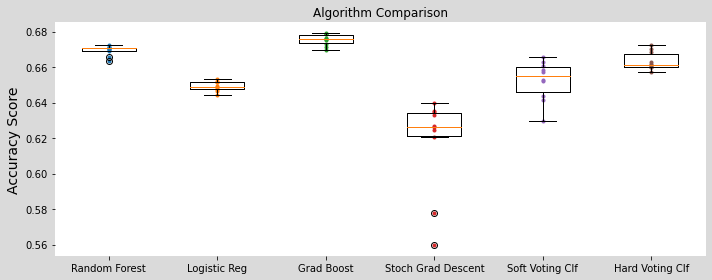

In [55]:
fig = plt.figure(figsize=(10, 4), facecolor='#dadada')

plt.plot([1] * 10, score_forest, ".")
plt.plot([2] * 10, score_lr, ".")
plt.plot([3] * 10, score_gb, ".")
plt.plot([4] * 10, score_sgd, ".")
plt.plot([5] * 10, score_voting_soft, ".")
plt.plot([6] * 10, score_voting_hard, ".")

plt.boxplot(
    [score_forest, score_lr, score_gb, score_sgd,
     score_voting_soft, score_voting_hard],
    labels=("Random Forest", "Logistic Reg", 'Grad Boost',
            'Stoch Grad Descent', 'Soft Voting Clf', 'Hard Voting Clf'))

plt.ylabel("Accuracy Score", fontsize=14)
plt.title('Algorithm Comparison')

# Remove the splines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["left"].set_visible(False)

plt.tight_layout()  # Makes it better looking on laptops

plt.show()

# Evaluating our model on Test set 

I picked the gradient boost classifer as it is the most generalized model. 

In [58]:
# transforming X_test 
X_test_transformed = final_pipeline.transform(X_test)

y_test_pred =gb.predict(X_test_transformed)

score = accuracy_score(y_test, y_test_pred)

In [59]:
print(f"""
    Accuracy score on the TRAINING set using gb Classifier: {score_gb.mean()}\n\n
    Accuracy score on TEST set using gb Classifier: {score}
    """)


    Accuracy score on the TRAINING set using gb Classifier: 0.6754044641751807


    Accuracy score on TEST set using gb Classifier: 0.6757306696263411
    


# Final Pipeline for Deployement

In [60]:
deploy_pipeline = make_pipeline(
                        final_pipeline, 
                        gb)  # Final Pick 

# Fitting the Pipeline 
deploy_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['name', 'usd_goal_real',
                                                   'length_days']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('imputerdf',
                                                                   ImputerDF()),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder

In [61]:
# Pickle the Pipeline using joblib
dump(deploy_pipeline, 'pipeline.joblib', compress=True)

['pipeline.joblib']

Get version of the packages used in the pipeline so we could then install all those packages in virtual env

In [67]:
print(f'joblib=={joblib.__version__}')
print(f'scikit-learn=={sklearn.__version__}')
print(f'category_encoders=={category_encoders.__version__}')

joblib==0.16.0
scikit-learn==0.23.1
category_encoders==2.2.2
